# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [75]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
from IPython.display import Image as _Imgdis
from IPython.display import display
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

for i in range(len(dog_names)):
    dog_names[i] = dog_names[i].split(".")[1]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

# test_files

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [76]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


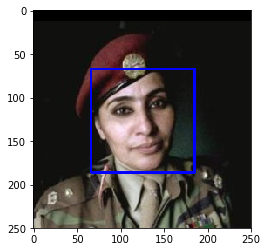

In [77]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [78]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector



In [130]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human = 0
dog = 0

for i in human_files_short:
    if face_detector(i):
        human+=1
for j in dog_files_short:
    if face_detector(j):
        dog+=1
print('Detected Human Face Accuracy:{:.0%}'.format(human/len(human_files_short)))
print('Detected Dog Face Accuracy:{:.0%}'.format(dog/len(dog_files_short)))

Detected Human Face Accuracy:100%
Detected Dog Face Accuracy:11%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [131]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [132]:
from keras.preprocessing import image                  
import cv2
from PIL import Image, ImageOps, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pandas as pd
import matplotlib.pyplot as plt
from time import time 


In [133]:
def py_resize(image):
    
#     img = cv2.imread(image)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.title('Old Image')
#     plt.show()
    
    desired_size = 256
    im_pth = image
    im = Image.open(im_pth)
    
    old_size = im.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    
    new_size = tuple([int(x*ratio) for x in old_size])
    
    # use thumbnail() or resize() method to resize the input image
    # thumbnail is a in-place operation
    im.thumbnail(new_size, Image.ANTIALIAS)
#     im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it
    new_im = Image.new("L", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))


    # display(new_im)
    new_im = np.array(new_im)
    new_im = cv2.resize(new_im, None, fx = .5, fy = .5, interpolation = cv2.INTER_LINEAR)
    return new_im

In [134]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
#     img = py_resize(img_path)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [135]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [136]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector



In [137]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_count = 0 
dog_count = 0
for i in range(100):
    if dog_detector(human_files_short[i]):
        human_count+=1
    if dog_detector(dog_files_short[i]):
        dog_count+=1
print('Human face Accuracy:{:.0%}'.format(human_count/len(human_files_short)))
print('Dog face Accuracy:{:.0%}'.format(dog_count/len(dog_files_short)))


Human face Accuracy:0%
Dog face Accuracy:100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [88]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:10<00:00, 82.89it/s] 


In [89]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization, Input, concatenate
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint


In [90]:
train_tensors[0].shape

(224, 224, 3)

In [91]:
### Define our Scratch Modell

from keras import backend as K


NUM_CLASSES = 133  ## Total number of Dog Breeds to classify

K.clear_session()
scratch_model = Sequential()

### TODO: Define your architecture.

INPUT_SHAPE = (224, 224, 3)   # H x W x C for ResNet

scratch_model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', 
                        input_shape=INPUT_SHAPE))
scratch_model.add(MaxPooling2D(pool_size=2))
scratch_model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
scratch_model.add(MaxPooling2D(pool_size=2))
scratch_model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
scratch_model.add(MaxPooling2D(pool_size=2))

scratch_model.add(Dropout(0.5))
scratch_model.add(Flatten())
scratch_model.add(Dense(256, activation='relu'))
scratch_model.add(Dropout(0.4))
scratch_model.add(Dense(NUM_CLASSES, activation='softmax'))


scratch_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 27, 64)        0         
__________

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()



### Compile the Model

In [92]:
scratch_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# scratch_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# from keras.optimizers import SGD
# epochs = 25
# lrate = 0.01
# decay = lrate/epochs
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
# scratch_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [93]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  

# datagen_train = ImageDataGenerator(
#         width_shift_range = 0.1,
#         height_shift_range = 0.1,
#         zoom_range = 0.2,
#         rotation_range = 25,
#         horizontal_flip = True)

# datagen_valid = ImageDataGenerator(
#         width_shift_range = 0.1,
#         height_shift_range = 0.1,
#         zoom_range = 0.2,
#         rotation_range = 25,
#         horizontal_flip = True)

# datagen_train.fit(train_tensors)
# datagen_valid.fit(valid_tensors)


epochs = 25

BATCH_SIZE = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

hist = scratch_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/25
6680/6680 [==============================] - 24s 4ms/step - loss: 4.8954 - acc: 0.0100 - val_loss: 4.8284 - val_acc: 0.0228
Epoch 2/25
6680/6680 [==============================] - 23s 3ms/step - loss: 4.6538 - acc: 0.0349 - val_loss: 4.4144 - val_acc: 0.0563
Epoch 3/25
6680/6680 [==============================] - 23s 3ms/step - loss: 4.2862 - acc: 0.0636 - val_loss: 4.2425 - val_acc: 0.0647
Epoch 4/25
6680/6680 [==============================] - 23s 3ms/step - loss: 3.9381 - acc: 0.1145 - val_loss: 4.1643 - val_acc: 0.0814
Epoch 5/25
6680/6680 [==============================] - 23s 3ms/step - loss: 3.5123 - acc: 0.1762 - val_loss: 4.1586 - val_acc: 0.0886
Epoch 6/25
6680/6680 [==============================] - 23s 3ms/step - loss: 3.0079 - acc: 0.2588 - val_loss: 4.2879 - val_acc: 0.0802
Epoch 7/25
6680/6680 [==============================] - 23s 3ms/step - loss: 2.5327 - acc: 0.3500 - val_loss: 4.4938 - val_acc: 0.0826
Epoch 8/

In [50]:
t0 = time()
hist = scratch_model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=BATCH_SIZE),
                    steps_per_epoch=train_tensors.shape[0] // BATCH_SIZE,
                    epochs=epochs, 
                    verbose=2, 
                    callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=BATCH_SIZE),
                    validation_steps=valid_tensors.shape[0] // BATCH_SIZE)

print("done in %0.3fs" % (time() - t0))


Epoch 1/25
Epoch 00001: val_loss improved from inf to 4.81343, saving model to saved_models/weights.best.from_scratch.hdf5
 - 61s - loss: 4.8843 - acc: 0.0107 - val_loss: 4.8134 - val_acc: 0.0144
Epoch 2/25
Epoch 00002: val_loss improved from 4.81343 to 4.46792, saving model to saved_models/weights.best.from_scratch.hdf5
 - 59s - loss: 4.6766 - acc: 0.0295 - val_loss: 4.4679 - val_acc: 0.0361
Epoch 3/25
Epoch 00003: val_loss improved from 4.46792 to 4.40414, saving model to saved_models/weights.best.from_scratch.hdf5
 - 59s - loss: 4.4597 - acc: 0.0424 - val_loss: 4.4041 - val_acc: 0.0493
Epoch 4/25
Epoch 00004: val_loss improved from 4.40414 to 4.24220, saving model to saved_models/weights.best.from_scratch.hdf5
 - 59s - loss: 4.3595 - acc: 0.0435 - val_loss: 4.2422 - val_acc: 0.0709
Epoch 5/25
Epoch 00005: val_loss did not improve
 - 59s - loss: 4.2580 - acc: 0.0580 - val_loss: 4.2556 - val_acc: 0.0697
Epoch 6/25
Epoch 00006: val_loss improved from 4.24220 to 4.19116, saving model to

### Load the Model with the Best Validation Loss

In [94]:
# model.load_weights('saved_models/weights.best.from_scratch.hdf5')
scratch_model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [95]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(scratch_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.0909%


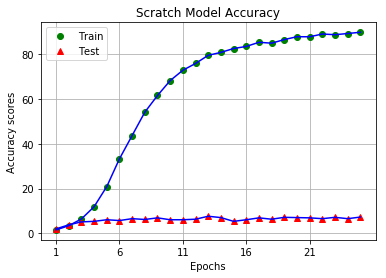

In [20]:
val_acc = [i*100 for i in hist.history['val_acc']]
acc = [j*100 for j in hist.history['acc']]

plt.title("Scratch Model Accuracy")
plt.xticks(np.arange(1, 26, step = 5.0))
x1 = np.arange(1, 26)
plt.plot(x1, acc, 'go')
plt.plot(x1, val_acc, 'r^')

plt.plot(x1, acc, color = 'b') 
plt.plot(x1, val_acc, color = 'b') 
plt.legend(['Train', 'Test'], loc='upper left')

plt.xlabel('Epochs')
plt.ylabel('Accuracy scores')

# plt.ylim(acc)
plt.grid(True)
plt.show()

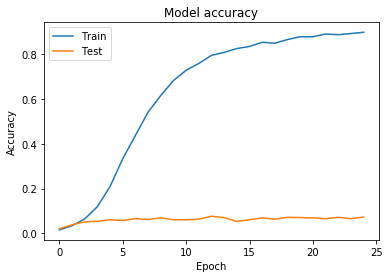

In [21]:
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

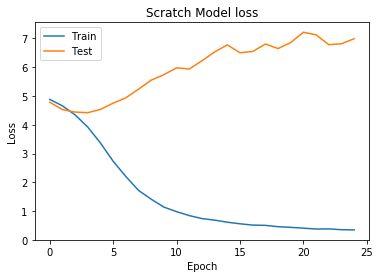

In [22]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Scratch Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [96]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']


In [97]:
print('Train bottleneck size {:,}, shape: {}'.format(train_Xception.size, train_Xception.shape))
print('Valid bottleneck size {:,}, shape: {}'.format(valid_Xception.size, valid_Xception.shape))
print('Test  bottleneck size {:,}, shape: {}'.format(test_Xception.size, test_Xception.shape))

Train bottleneck size 670,351,360, shape: (6680, 7, 7, 2048)
Valid bottleneck size 83,793,920, shape: (835, 7, 7, 2048)
Test  bottleneck size 83,894,272, shape: (836, 7, 7, 2048)


In [98]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [99]:
print('Train bottleneck size {:,}, shape: {}'.format(train_Resnet50.size, train_Resnet50.shape))
print('Valid bottleneck size {:,}, shape: {}'.format(valid_Resnet50.size, valid_Resnet50.shape))
print('Test  bottleneck size {:,}, shape: {}'.format(test_Resnet50.size, test_Resnet50.shape))

Train bottleneck size 13,680,640, shape: (6680, 1, 1, 2048)
Valid bottleneck size 1,710,080, shape: (835, 1, 1, 2048)
Test  bottleneck size 1,712,128, shape: (836, 1, 1, 2048)


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  Using transfer learning we build the final model's architecture, first we obtain the bottleck features of the Resnet50 and Xception networks which plays the role as feature extractor and feed those features as an input to our final model.   
Then we pool the features using Global Average Pooling. It is followed by a dense fully connected layer in which we squeeze the features into probability space and determine the most probable category for each image as the layer contains one node for each category and this layer uses 'Softmax' activation function.


In [103]:
### TODO: Define your architecture.

model_Xception = Sequential()
model_Xception.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
model_Xception.add(Dense(133, activation='softmax'))

model_Xception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [101]:
K.clear_session()

## Define our extension to the InceptionV3 model
model_Xception = Sequential()
# input shape is M x 5 x 5 x 2048
model_Xception.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
model_Xception.add(Activation('relu'))
model_Xception.add(Dense(1024, activation='relu'))
model_Xception.add(Dropout(0.5))
model_Xception.add(Dense(512, activation='relu'))
model_Xception.add(Dropout(0.5))
model_Xception.add(Dense(NUM_CLASSES, activation='softmax'))

model_Xception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
activation_1 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total para

In [102]:
model_Resnet50 = Sequential()
model_Resnet50.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
model_Resnet50.add(Dense(133, activation='softmax'))

model_Resnet50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [104]:
### TODO: Compile the model.
model_Xception.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_Resnet50.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [105]:
### TODO: Train the model.
import matplotlib.pyplot as plt
from time import time 

t0 = time()
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception = model_Xception.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

print("done in %0.3fs" % (time() - t0))


Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 449us/step - loss: 1.0531 - acc: 0.7359 - val_loss: 0.5520 - val_acc: 0.8263
Epoch 2/20
6680/6680 [==============================] - 3s 426us/step - loss: 0.3933 - acc: 0.8743 - val_loss: 0.4740 - val_acc: 0.8491
Epoch 3/20
6680/6680 [==============================] - 3s 423us/step - loss: 0.3199 - acc: 0.8990 - val_loss: 0.5027 - val_acc: 0.8491
Epoch 4/20
6680/6680 [==============================] - 3s 418us/step - loss: 0.2731 - acc: 0.9150 - val_loss: 0.4871 - val_acc: 0.8539
Epoch 5/20
6680/6680 [==============================] - 3s 420us/step - loss: 0.2418 - acc: 0.9277 - val_loss: 0.5208 - val_acc: 0.8515
Epoch 6/20
6680/6680 [==============================] - 3s 421us/step - loss: 0.2132 - acc: 0.9323 - val_loss: 0.5281 - val_acc: 0.8635
Epoch 7/20
6680/6680 [==============================] - 3s 428us/step - loss: 0.1914 - acc: 0.9398 - val_loss: 0.5449 - val_acc: 0.8563
E

In [107]:
from time import time 

t0 = time()
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

resnet = model_Resnet50.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

print("done in %0.3fs" % (time() - t0))


Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s 215us/step - loss: 0.0043 - acc: 0.9990 - val_loss: 0.9328 - val_acc: 0.8180
Epoch 2/20
6680/6680 [==============================] - 1s 213us/step - loss: 0.0039 - acc: 0.9988 - val_loss: 1.0084 - val_acc: 0.8251
Epoch 3/20
6680/6680 [==============================] - 1s 213us/step - loss: 0.0039 - acc: 0.9987 - val_loss: 1.0384 - val_acc: 0.8180
Epoch 4/20
6680/6680 [==============================] - 1s 214us/step - loss: 0.0046 - acc: 0.9984 - val_loss: 0.9911 - val_acc: 0.8216
Epoch 5/20
6680/6680 [==============================] - 1s 212us/step - loss: 0.0041 - acc: 0.9988 - val_loss: 1.0214 - val_acc: 0.8216
Epoch 6/20
6680/6680 [==============================] - 1s 211us/step - loss: 0.0044 - acc: 0.9987 - val_loss: 1.0520 - val_acc: 0.8263
Epoch 7/20
6680/6680 [==============================] - 1s 214us/step - loss: 0.0047 - acc: 0.9988 - val_loss: 1.0277 - val_acc: 0.8180
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [108]:
### TODO: Load the model weights with the best validation loss.
model_Xception.load_weights('saved_models/weights.best.Xception.hdf5')
model_Resnet50.load_weights('saved_models/weights.best.Resnet50.hdf5')

In [109]:
val_acc = [i*100 for i in Xception.history['val_acc']]
acc = [j*100 for j in Xception.history['acc']]

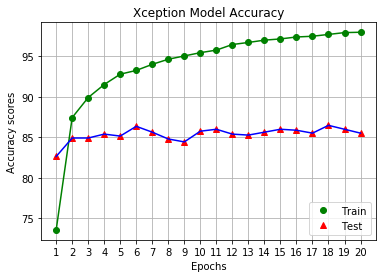

In [110]:
plt.title("Xception Model Accuracy")
plt.xticks(np.arange(1, 21, step = 1.0))
x1 = np.arange(1, 21)
plt.plot(x1, acc, 'go')
plt.plot(x1, val_acc, 'r^')

plt.plot(x1, acc, color = 'g') 
plt.plot(x1, val_acc, color = 'b') 
plt.legend(['Train', 'Test'], loc='lower right')

plt.xlabel('Epochs')
plt.ylabel('Accuracy scores')

# plt.ylim(acc)
plt.grid(True)
plt.show()

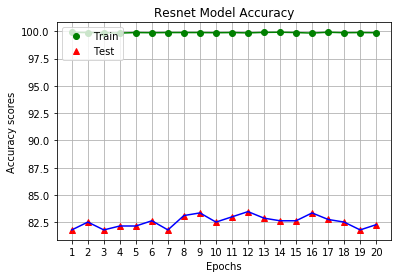

In [111]:
r_val_acc = [i*100 for i in resnet.history['val_acc']]
r_acc = [j*100 for j in resnet.history['acc']]


plt.title("Resnet Model Accuracy")
plt.xticks(np.arange(1, 21, step = 1.0))
x1 = np.arange(1, 21)
plt.plot(x1, r_acc, 'go')
plt.plot(x1, r_val_acc, 'r^')

plt.plot(x1, r_acc, color = 'g') 
plt.plot(x1, r_val_acc, color = 'b') 
plt.legend(['Train', 'Test'], loc='upper left')

plt.xlabel('Epochs')
plt.ylabel('Accuracy scores')
plt.grid(True)
plt.show()

In [37]:

def plots(history):
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(10,10))
    plt.subplot(221)

    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Xception Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid(True)
    plt.show()

    # Plot training & validation loss values
    plt.subplot(222)

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Xception Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

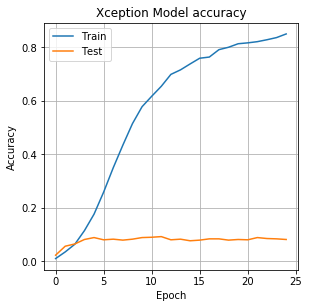

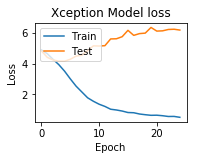

In [112]:
plots(Xception)

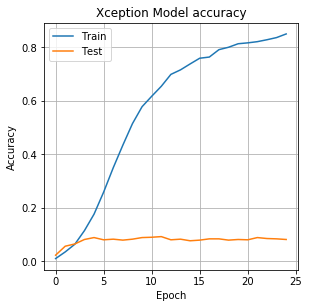

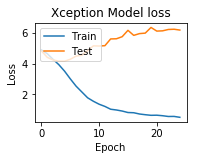

In [113]:
plots(resnet)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [114]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(model_Resnet50.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy Resnet50: %.4f%%' % test_accuracy)

Xception_predictions = [np.argmax(model_Xception.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy1 = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy Xception: %.4f%%' % test_accuracy1)
# np.array(Xception_predictions).shape[0]
len(test_targets)

Test accuracy Resnet50: 80.9809%
Test accuracy Xception: 82.8947%


836

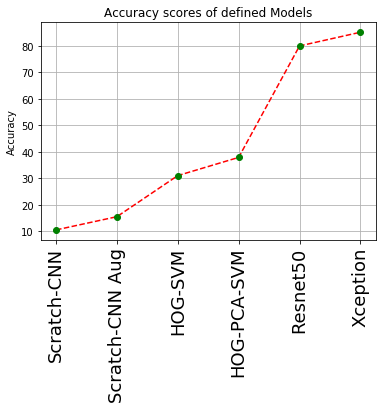

In [115]:
x = np.arange(2,13,2)
y = [10.5, 15.5, 31.03, 37.9, 80.03, 85.2]

x_ticks_labels = ['Scratch-CNN', 'Scratch-CNN Aug', 'HOG-SVM', 'HOG-PCA-SVM','Resnet50', 'Xception']

fig, ax = plt.subplots(1,1) 
ax.plot(x,y, 'r--')
plt.title("Accuracy scores of defined Models")

# Set number of ticks for x-axis
ax.set_xticks(x)
# Set ticks labels for x-axis
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=18)
plt.plot(x, y, 'go')
plt.ylabel('Accuracy')
plt.grid(True)

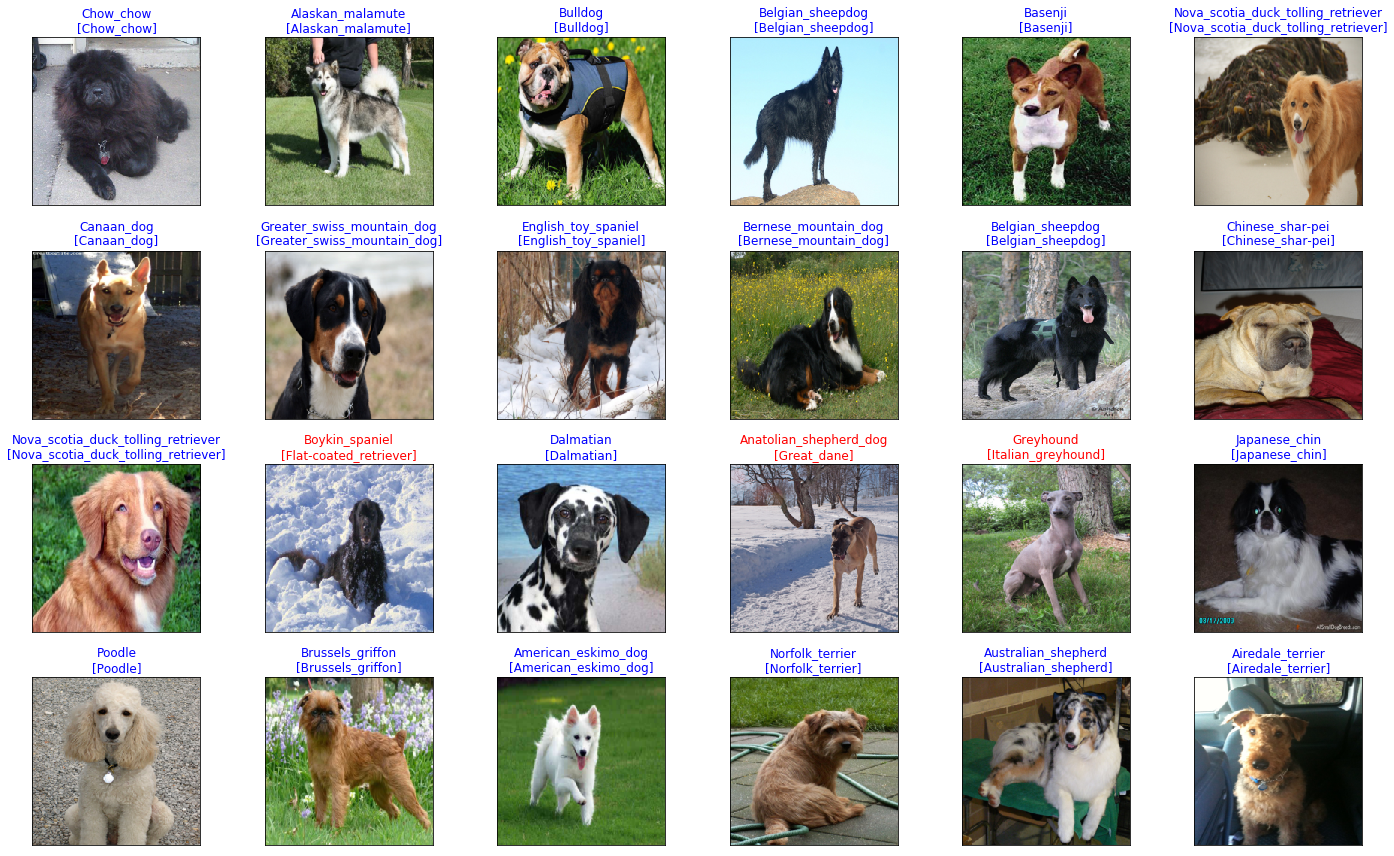

In [116]:
fig = plt.figure(figsize=(20, 12))

for i, ix in enumerate(np.random.choice(test_tensors.shape[0], size=24, replace=False)):
    ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_tensors[ix]))
    # correct img ix
    true_index = np.argmax(test_targets[ix])
    # predicted img ix
    pred_index = Xception_predictions[ix]
    ax.set_title('{}\n[{}]'.format(dog_names[pred_index], dog_names[true_index]),
                color=('blue' if pred_index == true_index else 'red'))
plt.tight_layout()

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [143]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def predict_breed_Resnet50(pic_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(pic_path))
    # obtain predicted vector
    predicted_vector = model_Resnet50.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    pic = cv2.imread(pic_path)
    color = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.show()
    name_index = dog_names[np.argmax(predicted_vector)]
#     dog_name = name_index.split(".")
    return name_index

def predict_breed_Xception(pic_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(pic_path))
    # obtain predicted vector
    predicted_vector = model_Xception.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    pic = cv2.imread(pic_path)
    color = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.show()
    name_index = dog_names[np.argmax(predicted_vector)]
#     dog_name = name_index.split(".")
    return name_index
    

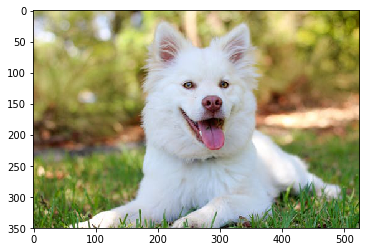

'American_eskimo_dog'

In [118]:
predict_breed_Xception('my_pics/1.jpg')

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [138]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import cv2

def breed_classifier_Xception(path):
    
    if dog_detector(path):
        print("That is a Dog !!!")
        print("The predicted dog breed is:", predict_breed_Xception(path))
        
    elif face_detector(path):
        
        print("This is a Human")
        print("The Human Resembles a Dog breed:", predict_breed_Xception(path))
    
    else:
        print("This is not a Dog or Human")
        print("This Resembles a Dog breed:", predict_breed_Xception(path))


In [139]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import cv2

def breed_classifier_Resnet50(path):
    
    if dog_detector(path):
        print("That is a Dog !!!")
        print("The predicted dog breed is:", predict_breed_Resnet50(path))
        
    elif face_detector(path):
        
        print("This is a Human")
        print("The Human Resembles a Dog breed:", predict_breed_Resnet50(path))
    
    else:
        print("This is not a Dog or Human")
        print("This Resembles a Dog breed:", predict_breed_Resnet50(path))


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__  Yes, the output is better than my expectation and it gives good satisfaction on seeing fruitful results. I have defined two models Resnet50 and Xception whose testing accuracies are Resnet50 is 80.03% and Xception model gives 84.9% which is considerably good accuracy scores.

Improvement: 
I see myself at very basic level in dealing with deep learning concepts like CNN, this project gave me good intuition, however I have to learn so much. I could see a good improvement in myself.
Coming to the improvemt of the algorithm:
1. Face detector algorithm could be more accurate on detecting faces as it sometimes misclassifies the human face as 'neither dog or human'. When we predicted the accuracy for dog images with face_detector algorithm, it gave 11% accuracy for first 100 images of humans as dogs which is wrong prediction probability that can be brought down to 0% by improving the face detector algorithm.

2. Training can be made on large number of samples in the dataset with large number of dog breeds not just limiting to few. 

3. As I trained the CNN with the basic hint architecture provided. I can improve my algorithm by adding few more filters, more layers of network and could also try different activation functions at layers.

4. Augmenting data images could also improve performance of the algorithm.

That is a Dog !!!


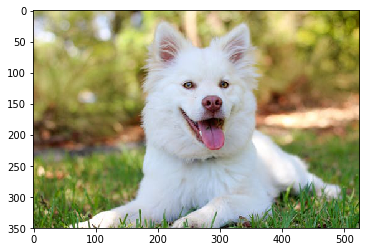

The predicted dog breed is: American_eskimo_dog


In [140]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

breed_classifier_Xception('my_pics/1.jpg')


That is a Dog !!!


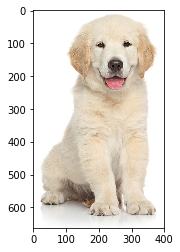

The predicted dog breed is: Golden_retriever


In [78]:
breed_classifier_Resnet50('my_pics/2.jpg')


This is a Human


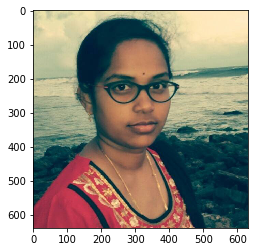

The Human Resembles a Dog breed: Dachshund


In [141]:
breed_classifier_Xception('my_pics/14.jpg')

This is a Human


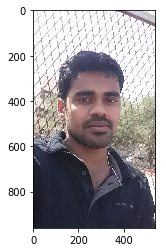

The Human Resembles a Dog breed: Cane_corso


In [144]:
breed_classifier_Resnet50('my_pics/11.jpg')


This is a Human


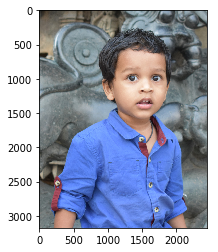

The Human Resembles a Dog breed: Chinese_crested


In [145]:
breed_classifier_Xception('my_pics/9.jpg')

That is a Dog !!!


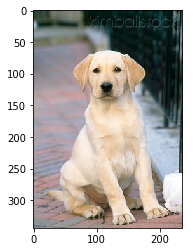

The predicted dog breed is: Labrador_retriever


In [91]:
breed_classifier_Resnet50('my_pics/y.jpg')


This is not a Dog or Human


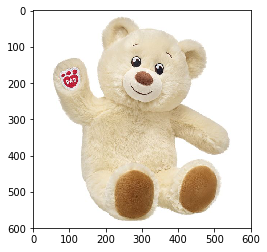

This Resembles a Dog breed: Cavalier_king_charles_spaniel


In [75]:
breed_classifier_Xception('my_pics/10.jpg')

That is a Dog !!!


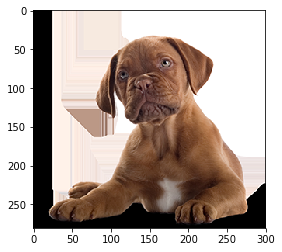

The predicted dog breed is: Dogue_de_bordeaux


In [76]:
breed_classifier_Resnet50('my_pics/3.jpg')


That is a Dog !!!


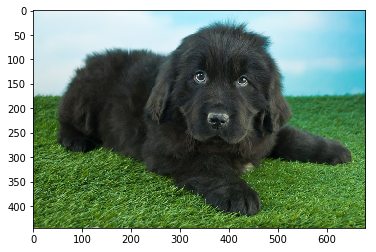

The predicted dog breed is: Newfoundland


In [77]:
breed_classifier_Xception('my_pics/4.jpg')

That is a Dog !!!


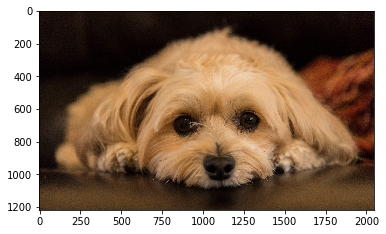

The predicted dog breed is: Havanese


In [79]:
breed_classifier_Resnet50('my_pics/8.jpg')


This is not a Dog or Human


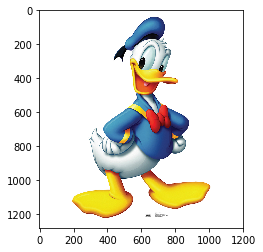

This Resembles a Dog breed: Chinese_shar-pei


In [80]:
breed_classifier_Xception('my_pics/12.jpg')

This is not a Dog or Human


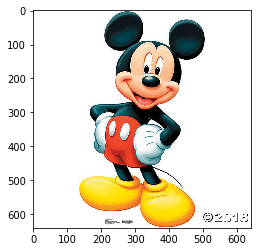

This Resembles a Dog breed: Bichon_frise


In [81]:
breed_classifier_Resnet50('my_pics/13.jpg')


# Please download your notebook to submit

In order to submit, please do the following:
1.  Download an HTML version of the notebook to your computer using 'File: Download as...'
2.  Click on the orange Jupyter circle on the top left of the workspace.
3.  Navigate into the dog-project folder to ensure that you are using the provided dog_images, lfw, and bottleneck_features folders; this means that those folders will *not* appear in the dog-project folder.  If they do appear because you downloaded them, delete them.
4.  While in the dog-project folder, upload the HTML version of this notebook you just downloaded.  The upload button is on the top right.
5.  Navigate back to the home folder by clicking on the two dots next to the folder icon, and then open up a terminal under the 'new' tab on the top right
6.  Zip the dog-project folder with the following command in the terminal:
 `zip -r dog-project.zip dog-project`
7.  Download the zip file by clicking on the square next to it and selecting 'download'.  This will be the zip file you turn in on the next node after this workspace!